In [1]:
#%matplotlib inline
#%autosave 40
#%load_ext autoreload
#%autoreload 2

In [2]:
import sys  
if '..' not in sys.path: # My notebooks are usually one directory in.
    sys.path.append('..')

In [3]:
from msa.adaboost import Adaboost
from msa.stump import Stump
from msa.binary_feature_converter import Binary_feature_converter
from msa.import_data import get_data_frame

In [4]:
import pandas as pd
import numpy as np 
from joblib import delayed,Parallel

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.model_selection import StratifiedKFold 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from atpbar import atpbar

e_n_fold = 3
i_n_fold = 3

random_state=42
randomization = False
on_perform = True


sub_name = '' #f'{"perf_" if on_perform else ""}{"rnd" if randomization else "no_rnd"}'

file_name = 'forest-cover-type.csv'
path_relazione = '../../../relazione/img/'
path_output = 'saving/'
path = '../../data/'

## Import dataframe
Vengono rimosse in automatico i *Soil_TypeX* con $X \ge 9$ in quanto il Soil_type rappresenta la codifica one-hot-enoding di una variabile discreta e da essi si può ricostruire la 

In [5]:
df = get_data_frame(path + file_name)
print(df.columns)
df.head()

Path:  ../../data/forest-cover-type.csv
Colonne tot:  55
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_T

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6279  ...            0            0   
1                                6225  ...            0            0   
2                                6121  ...            0            0   
3                                6211  ...            0            0   
4                                6172  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type39  Soil_Type40  Cover_Type  
0            0            0           5  
1            0            0           5  
2            0            0           2  
3            0            0           2  
4            0            0           5  

[5 rows x 55 columns]

In [6]:
cols_label = np.unique(df['Cover_Type'])
dfs = [ df.assign(y = df['Cover_Type'].apply(lambda x: 1 if x == el else -1)).drop('Cover_Type',axis=1)  for el in cols_label]

In [7]:
dfs[4].head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6279  ...            0            0   
1                                6225  ...            0            0   
2                                6121  ...            0            0   
3                                6211  ...            0            0   
4                                6172  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type39  Soil_Type40  y  
0            0            0  1  
1            0            0  1  
2            0            0 -1  
3            0            0 -1  
4            0            0  1  

[5 rows x 55 columns]

## Sanity check su comportamento rispetto a margine e train/valid error
Preso un dataset a caso si valutano le prestazioni, distribuzioni dei parametri quali pesi alpha ecc.

In [10]:
import time
round_max = 1000
n_fold = 3
skf = StratifiedKFold(n_splits=4, random_state=random_state, shuffle=True)


X = dfs[1].drop(['y'],axis=1).to_numpy()
y = dfs[1]['y'].to_numpy()

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X,y = unison_shuffled_copies(X,y)


error = np.zeros((round_max,2),dtype=object)
_skf = iter(skf.split(X,y))

i_train_index, validation_index = next(_skf)
X_i_train, X_val, y_i_train, y_val = X[i_train_index], X[validation_index], y[i_train_index], y[validation_index]

ada = Adaboost(max_round=round_max, learning_algo=Stump)
last_time = time.time()
for nth,t in enumerate(ada.train(X=X_i_train,y=y_i_train,save_statistics=True,stops_at_round = True)):
    error[nth,0] = (t.predict(X_val)!=y_val).sum()/len(y_val)
    error[nth,1] = ada.training_error[nth]
    if nth%10==0:
        print(f'Nth: {nth} error: {error[nth,:]}')
print((time.time() - last_time)/round_max)

Nth: 0 error: [0.13253968253968254 0.13051146384479717]
Nth: 10 error: [0.1298941798941799 0.12574955908289243]
Nth: 20 error: [0.12169312169312169 0.11825396825396825]
Nth: 30 error: [0.12195767195767196 0.11957671957671957]
Nth: 40 error: [0.11984126984126985 0.1162257495590829]
Nth: 50 error: [0.11931216931216931 0.11437389770723104]
Nth: 60 error: [0.11957671957671957 0.11393298059964727]
Nth: 70 error: [0.11931216931216931 0.113668430335097]
Nth: 80 error: [0.11746031746031746 0.11137566137566138]
Nth: 90 error: [0.11798941798941799 0.11119929453262786]
Nth: 100 error: [0.1164021164021164 0.11349206349206349]
Nth: 110 error: [0.11798941798941799 0.11190476190476191]
Nth: 120 error: [0.1164021164021164 0.11128747795414462]
Nth: 130 error: [0.11746031746031746 0.11137566137566138]
Nth: 140 error: [0.1156084656084656 0.11049382716049383]
Nth: 150 error: [0.11481481481481481 0.10925925925925926]
Nth: 160 error: [0.11587301587301588 0.10881834215167549]
Nth: 170 error: [0.1153439153439

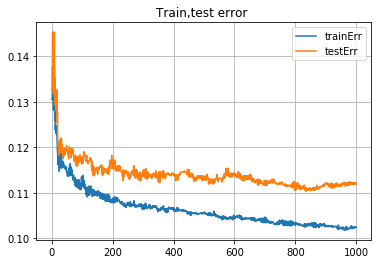

In [11]:
rounds = range(error.shape[0]) 

train = error[:,1]
test = error[:,0]
plt.plot(rounds,train,label=f'trainErr')
plt.plot(rounds,test,label=f'testErr')
plt.grid(True)
plt.legend()
plt.title(f'Train,test error ')
plt.savefig(path_relazione + f'general_train_test_error.pdf')
plt.show()

In [12]:
#cumulative frequency at fixed rounds
num_bins = 500

@interact
def plt_margin_distribution(reference_round = widgets.IntSlider(min=0, max=round_max-1, step=1, value=0),\
                           other_round = widgets.IntSlider(min=0, max=round_max-1, step=1, value=int(round_max*0.3)),\
                           other_round_1 = widgets.IntSlider(min=0, max=round_max-1, step=1, value=int(round_max*0.9)),\
                           other_round_2 = widgets.IntSlider(min=0, max=round_max-1, step=1, value=int(round_max*0.9))              ):
    def plot_distr(name,data):
        margins = np.array(data)/max(data + np.finfo(float).eps)
        H,X = np.histogram( margins, bins = num_bins, normed = True )
        dx = X[1] - X[0]
        F = np.cumsum(H)*dx
        plt.plot(X[1:],F,label=name)
        
    plot_distr(f'dist {reference_round + 1}°',ada.margin_distribution[reference_round])
    plot_distr(f'dist {other_round}', ada.margin_distribution[other_round])
    plot_distr(f'dist {other_round_1}', ada.margin_distribution[other_round_1])
    plot_distr(f'dist {other_round_2}', ada.margin_distribution[other_round_2])
    plt.xlim((-1.05,+1.05))
    plt.ylim((0,1))
    plt.title("Margin distribution")
    plt.legend()
    plt.savefig(path_relazione + f'general_increment_margin_over_rounds.pdf')
    plt.show()

interactive(children=(IntSlider(value=0, description='reference_round', max=999), IntSlider(value=300, descrip…

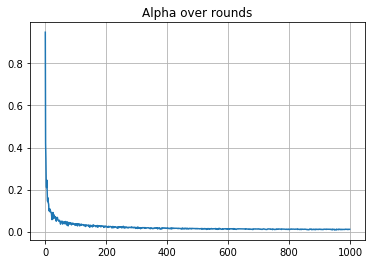

In [13]:
x=ada.alpha
plt.grid(True)
plt.plot(range(len(x)),x)
plt.title("Alpha over rounds")
plt.savefig(path_relazione + f'general_alhpa_over_rounds.pdf')
plt.show()

In [14]:
@interact
def plot_perc_of_weight(n_perc: widgets.IntSlider(min=1, max=10, step=1, value=6), \
                        bound: widgets.IntRangeSlider(value = [20,80],min=0,max = 101)):
    lower, higher = bound
    p = list(range(lower,higher, int((higher -lower)/n_perc)  ))
    perc = [np.percentile(w_s,p) for w_s in ada.weight_distribution ]
    for nth,_p in enumerate(p):
        plt.plot(range(len(perc)),  [ i[nth] for i in perc], label=f'{_p}-th perc')
    
    plt.legend()
    plt.grid(True)
    plt.title(f'Weight percentiles over rounds')
    plt.savefig(path_relazione + f'general_weight_perc_over_rounds.pdf')
    plt.show()    

interactive(children=(IntSlider(value=6, description='n_perc', max=10, min=1), IntRangeSlider(value=(20, 80), …

## Sanity check su comportamento rispetto a margine e train/valid error
Preso un dataset a caso si valutano le prestazioni, distribuzioni dei parametri quali pesi alpha ecc.

In [12]:
round_max = 20

e_skf = StratifiedKFold(n_splits=e_n_fold, random_state=random_state, shuffle=True)
i_skf = StratifiedKFold(n_splits=i_n_fold, random_state=random_state, shuffle=True)


X = dfs[0].drop(['y'],axis=1).to_numpy()
y = dfs[0]['y'].to_numpy()

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X,y = unison_shuffled_copies(X,y)

def _train_on_nth(i_nth,i_other,*args,**kwargs):
    name = f'fold {i_nth}'
    _err = np.zeros((round_max,3),dtype=object)
    i_train_index, validation_index = i_other
    X_i_train, X_val, y_i_train, y_val = X[i_train_index], X[validation_index], y[i_train_index], y[validation_index]

    ada = Adaboost(max_round=round_max, learning_algo=Stump)
    for nth,t in enumerate(ada.train(X=X_i_train,y=y_i_train,save_statistics=True,stops_at_round = True)):
        _err[nth,0] = (t.predict(X_val)!=y_val).sum()/len(y_val)
        _err[nth,1] = ada.training_error[nth]
        _err[nth,2] = ada
    return _err


error = Parallel(n_jobs=min(e_n_fold,3))(delayed(_train_on_nth)(i_nth, i_other) for i_nth, i_other in enumerate(i_skf.split(X,y)))
error = np.array(error)

In [8]:
np.save(f'{path_output}{sub_name}_3_fold_100_round.npy',error)
error = np.load(f'{path_output}{sub_name}_3_fold_100_round.npy',allow_pickle=True)
error.shape

(3, 100, 3)

In [ ]:
rounds = range(error.shape[1]) 

def _plot_tt(nth):
    train = error[nth,:,1]
    test = error[nth,:,0]
    plt.plot(rounds,train,label=f'{nth+1}-fold trainErr')
    plt.plot(rounds,test,label=f'{nth+1}-fold testErr')
[ _plot_tt(nth) for nth in range(e_n_fold)]
plt.grid(True)
plt.legend()
plt.title(f'Train,test error from {e_n_fold}')
plt.savefig(path_relazione + f'{sub_name}_train_test_error.pdf')
plt.show()

In [25]:
import pickle
import sys
with open('ada.pickle','w+b') as f:
    pickle.dump(ada,f)
with open('error.pickle','w+b') as f:
    pickle.dump(error,f)